<a name="top"> <h1>4. Model Selection</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias](#librerias) 


[2. Comparación de modelos](#modelos) 

[3. Carga de datos](#datos) 

[4. Creación del modelo XGBoost](#creacion) 

   
[5. Optimización del modelo](#optimizacion) 

   
[6. Predicción del modelo](#prediccion)

[7. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F0.5, F1
   - Curva ROC
   
[8. Conclusiones Generales](#conclusiones)

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento **realizaremos una recopilación de la métrica Accuracy, F0.5 y AUC para comparar los modelos que hemos realizado** durante este estudio. Una vez comparados, **seleccionaremos aquel que mejor score haya obtenido** y trataremos de optimizarlo ajustando las mejores métricas. 

# <a name="librerias"> 1. Importación de librerias y funciones <a> 


In [4]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve,roc_auc_score, fbeta_score, make_scorer, plot_confusion_matrix
import scikitplot as skplt


# Import sklearn models and pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

# <a name="modelos"> 2. Comparación de modelos <a> 


Procedemos a crear una tabla donde podamos observar las métricas de los modelos. 

Como ya comentamos en el documento `3.1_DummyModel`, nuestro dataset se caracteriza por tener un desbalanceo muy grande, es por ello que el análisis de las métricas de accuracy y precisión siempre van a ser muy elevadas, sin embargo, no reflejan la realidad predictora de nuestro modelo. Por lo que nos centraremos principalmente en las métrica F0.5 score y AUC .

**Seleccionaremos aquella que tenga un F0.5 superior. Dado que para nuestro problema, nos interesa centrarnos en que trate de reconocer de la forma más precisa si un restaurante va  atener una pntuación alta o no, con el menor número posible de falsos positivos.**

In [5]:
# Create a DF with the record of the F2 metric.

model_data = {'Modelo': ['Dummy', 'Logistic Regression', 'Random Forest','LightGBM','SVM', 'XGBoost'],

                'Accuracy': ['0.53', '0.73', '0.74', '0.75', '0.73', '0.74'],
                'AUC': ['0.5', '0.80', '0.82', '0.836', '0.80', '0.83'],
                'F0.5': ['0', '0.71', '0.731', '0.737', '0.714', '0.732']}

tabla_modelos = pd.DataFrame(model_data, columns=['Modelo', 'Accuracy', 'AUC', 'F0.5'])


# Print tabla_modelos

tabla_modelos.sort_values(by='AUC',ascending=False).set_index("Modelo")

,Accuracy,AUC,F0.5
Modelo,,,
LightGBM,0.75,0.836,0.737
XGBoost,0.74,0.83,0.732
Random Forest,0.74,0.82,0.731
Logistic Regression,0.73,0.80,0.71
SVM,0.73,0.80,0.714
Dummy,0.53,0.5,0


Como vemos reflejado en la tabla, **el modelo que mejor se ha comportado ha sido el LightGBM**. Es por ello que procederemos a optimizarlo y a obtener las predicciones de la función de test.

# <a name="datos"> 3. Carga de datos <a> 

Para la optimización del modelo, procederemos a cargar las funciones que usaremos, el set de train y validación juntos y el set de test, para predecir los datos sobre el.

In [6]:
# Import the functions to use in the notebook.

from aux_functions import load_model, save_model


#Load the preprocessor

preprocessor = load_model('../models/preprocessor.pickle')

# Load the train dataset separated by other variables and target. 

x_train_all = pd.read_parquet("../data/processed/x_train_all.parquet").reset_index(drop=True)
y_train_all = pd.read_parquet("../data/processed/y_train_all.parquet").reset_index(drop=True)['stars']

# Load the test dataset separated by other variables and target. 

x_test = pd.read_parquet("../data/processed/x_test.parquet")
y_test = pd.read_parquet("../data/processed/y_test.parquet")['stars']

# <a name="creacion"> 4. Creación del modelo LightGBM <a> 

Creamos el Pipeline del modelo, con el preprocesado y el algoritmo en su interior.

In [7]:
# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

lightgbm_model_test = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', lgb.LGBMClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])

# <a name="optimizacion"> 5. Optimización del modelo <a> 

Para optimizar el modelo realizaremos pruebas con diferentes hiperparámetros y nos quedaremos con aquel que mayor AUC nos devuelva.

In [61]:
# A parameter grid for XGBoost
params = {
        'clasificador__num_leaves': [40, 50, 60, 100, 120],
        'clasificador__min_child_samples': [20, 30, 40, 50],
        'clasificador__learning_rate': [0.01, 0.05]
        }

In [62]:
# Search the best model with the grid created before.

random_state = 12345
scoring='roc_auc'
n_jobs= -1

search = GridSearchCV(lightgbm_model_test, params,scoring=scoring)
search.fit(x_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('short_cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant',
                                                                                                        verbose='deprecated')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse='deprecated'))]),
                            

In [64]:
# Save backup of the best grid.

save_model(search,'../models/search.pickle')

Observamos los parametors y score resultantes:

In [68]:
# Print best grid.

print(search.best_params_)    
print(search.best_score_)

{'clasificador__learning_rate': 0.05, 'clasificador__min_child_samples': 20, 'clasificador__num_leaves': 100}
0.8345247541630461


Tras realizar la optimización del modelo con algunos hiperparámetros observamos que tenemos un AUC ROC ligeramente menor que el logrado previamente, sin embargo, hay que tener en cuenta que el dataset entrenado ahora contiene mayor información, por lo que será el que aplciaremos sobre el set de test.

**Para evitar optimizar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.**

In [8]:
# Load the XGB model already fitted in /models.

search = load_model('../models/search.pickle')


In [85]:
# Design the parameters.

n_jobs = -1
random_state = 12345
learning_rate = 0.05
min_child_samples = 20
num_leaves = 100

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

lightgbm_model_test = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', lgb.LGBMClassifier(learning_rate=learning_rate, min_child_samples=min_child_samples, num_leaves=num_leaves,n_jobs=n_jobs, random_state=random_state )
    )
])


In [86]:
# Optimization of the light_gbm with the train set: input and target data. 

lightgbm_model_test.fit(x_train_all, y_train_all)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('short_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant',
                                                                                 verbose='deprecated')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse='deprecated'))]),
                                                  ['attributes_ByAppointmentOnly',
                                                   'attributes_BusinessAcceptsCreditCards',
                                                   'attribut

In [88]:
# Save backup of the model with the parameters.

save_model(lightgbm_model_test,'../models/lightgbm_model_test.pickle')

# <a name="prediccion"> 6. Predicción del modelo <a> 

In [9]:
# Predict the target value of the validation set.

predictions = search.predict(x_test)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = search.predict_proba(x_test)

Una vez obtenidas las probabilidades, representamos el histograma de densidad de la predicción:

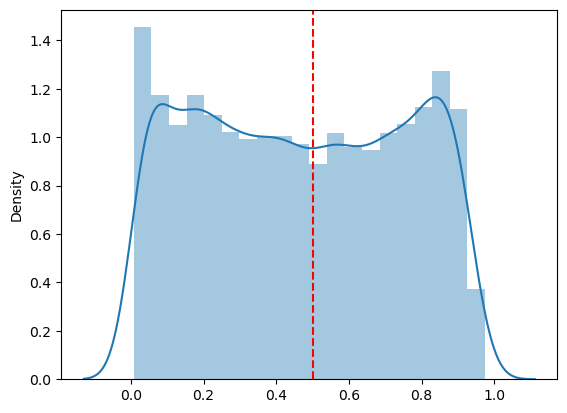

In [10]:
# Parametric density histogram of the predicted probabilities, shwoing the treshold of 0.5.

sns.distplot(predict_probabilities[:,1], kde=True, rug=False, bins=20)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()


Obtenemos un histograma prácticamente identico al obtenido en el set de validación, por lo que es buena señal al no tener gran diferencia, puesto que muestra que el modelo va a tener un funcionamiento similiar al testeado.

# <a name="metricas"> 7. Evaluación de las métricas del modelo <a> 

### 7.1. Matriz de confusión

Confusion matrix, without normalization
[[3524 1106]
 [1108 2891]]
Normalized confusion matrix
[[0.76112311 0.23887689]
 [0.27706927 0.72293073]]


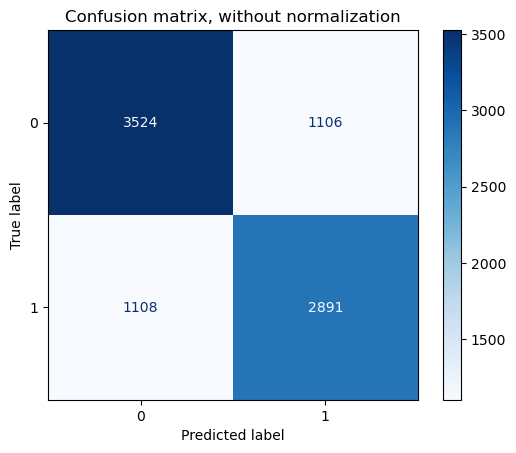

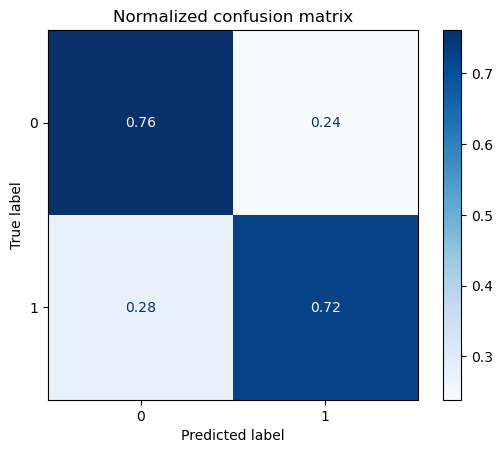

In [11]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(search, x_test, y_test,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Sobre el set de test, mantiene unos resultados similares al estudiado en `3.4.LightGBM`, llegando a clasificar un 72% de los restaurantes con alta puntuación correctamente.

### 7.2. Métricas: Accuracy, Recall, Precision,F0.5 y F1 score

In [13]:
# Print the general metrics.

print(classification_report(y_test, predictions))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_test, predictions))

# F 0.5 score.

print('F0.5 score is ' +str(fbeta_score(y_test, predictions, average='binary', beta=0.5)))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      4630
           1       0.72      0.72      0.72      3999

    accuracy                           0.74      8629
   macro avg       0.74      0.74      0.74      8629
weighted avg       0.74      0.74      0.74      8629

Accuracy: 0.743423339900336
F0.5 score is 0.7232200930604893


**Como vemos el F0.5 score se comporta muy similar al estudiado sobre el set de train, aunque para el test obtenemos un resultado algo inferior.**

### 7.3. Curva ROC

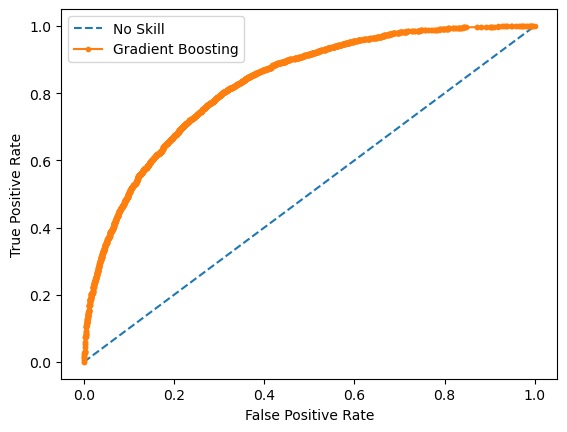

The Compute Area Under the Receiver Operating Characteristic is 0.8274365027541982


In [73]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(metrics.roc_auc_score(y_test,yhat)))

**En cuanto al AUC, es muy similar al resultado obtenido con el set de validación, por lo que consideramos que el modelo es funcional.**

# <a name="conclusiones"> 8. Conclusiones Generales <a> 

**- Para la elección del modelo nos hemos basado principalmente en el score AUC y F0.5 dado que al estar en un problema de clases binarias, dodne debemos reducir el número de falsos positivos, son los que mejor muestran el funcionamiento del modelo.**

**- El modelo que mejor se ha comportado basandonos en las métricas ha sido el LightGBM.**

**- Durante la realización de optimización no hemos podido conseguir mejorarlo, sin embargo, contando con mayor tiempo de computación e introduciendo más parametros, estamos seguros de que podría mejorar los resultados del modelo.**

**- Los resultados del modelo optimizado para el set de train han sido los esperados. Han sido muy similares a los de validación, por lo que descartamos que haya habido overfitting y declaramos el modelo como funcional.**

[Ir arriba del documento](#top)